In [46]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from skimage.measure import label, regionprops
import math
from matplotlib.ticker import MaxNLocator

In [47]:
plt.rcParams['figure.dpi'] = 300
plt.style.use("default")
font = {'family': 'sans-serif', 'sans-serif': ['Myriad Pro'], 'size': 14}
matplotlib.rc('font', **font)

import config

In [48]:
unit = (32, 48)
crop_size = 13
CROP = True

In [49]:
models = ['Fully_Trained', 'Pretrained_Directional', 'Randomly_Initialized', 'Shuffled_Directional', 'Pretrained_Godfrey', 'Pretrained_Directional_One_Epoch']
designs = {
    'Pretrained_Directional': {'color': '#0065bd', 'marker': 'o', 'linewidth': 2},
    'Randomly_Initialized': {'color': '#4cc997', 'marker': 'v', 'linewidth': 2},
    'Fully_Trained': {'color': '#000000', 'marker': 'h', 'linewidth': 2},
    'Shuffled_Directional': {'color': '#cc323f', 'marker': '.', 'linewidth': 2},
    'Pretrained_Godfrey': {'color': '#d6a319', 'marker': 'x', 'linewidth': 2},
    'Pretrained_Directional_One_Epoch': {'color': '#bf4492', 'marker': 'P', 'linewidth': 2}
}

In [50]:
def calc_rf_size(model):
    print(f'Investigating Model: {model}')
    
    data = np.load(
        f'{config.project_dir}/01_Output/Receptive_Field_Investigation_Per_Model/{model}/five_model_average.npy')
    if CROP:
        data = data[:, unit[0]-crop_size:unit[0]+crop_size+1, unit[1]-crop_size:unit[1]+crop_size+1]

    rf_diameter_model = []
    for frame in range(10):
        target = data[frame, :, :]
        target[target > 0.1] = 1

        label_img = label(target)
        regions = regionprops(label_img)
        
        if frame == 0 or frame == 9:
            plot_detected_rf(target, regions)
        
        assert len(regions) == 1, "More than one blob found!"
        rf_diameter_model.append(regions[0].minor_axis_length / 2)
        
    return rf_diameter_model


def plot_detected_rf(target, regions):
    fig, ax = plt.subplots(figsize=(2, 2))
    ax.imshow(target, cmap=plt.cm.gray)
    for props in regions:
        y0, x0 = props.centroid
        orientation = props.orientation
        x1 = x0 + math.cos(orientation) * 0.5 * props.major_axis_length
        y1 = y0 - math.sin(orientation) * 0.5 * props.major_axis_length
        x2 = x0 - math.sin(orientation) * 0.5 * props.minor_axis_length
        y2 = y0 - math.cos(orientation) * 0.5 * props.minor_axis_length
    
        ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
        ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
        ax.plot(x0, y0, '.g', markersize=15)
    
        minr, minc, maxr, maxc = props.bbox
        bx = (minc, maxc, maxc, minc, minc)
        by = (minr, minr, maxr, maxr, minr)
        ax.plot(bx, by, '-b', linewidth=2.5)
        plt.show()


def plot_rf_size_over_frames(save_path, rf_diameter, model_list):
    fig, ax = plt.subplots(figsize=(3.4, 2.8))
    
    for model in model_list:
        y = rf_diameter[model]
        design = designs[model]
        ax.plot(range(1,11), y, **design)
    
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    plt.ylabel('Radius of recep-\ntive field in pixel')
    plt.xlabel('Frame')
    ax.grid(True, alpha=0.2, color='black')
    plt.savefig(f'{save_path}/RF_size.pdf', bbox_inches='tight')
    plt.show()


def calc_rf_strength(model):
    
    data = np.load(
        f'{config.project_dir}/01_Output/Receptive_Field_Investigation_Per_Model/{model}/five_model_average.npy')
    if CROP:
        data = data[:, unit[0]-crop_size:unit[0]+crop_size+1, unit[1]-crop_size:unit[1]+crop_size+1]
    
    rf_strengths[model] = []
    for frame in range(10):
        target = data[frame, :, :]
        target = target[target > 0.05]
        percentile_95_activation = np.percentile(target, 95)
        rf_strengths[model].append(percentile_95_activation)
    
    return rf_strengths[model]


def plot_rf_strength_over_frames(save_path, rf_strength, model_list):
    fig, ax = plt.subplots(figsize=(3.4, 2.8))
    for model in model_list:
        y = rf_strength[model]
        design = designs[model]
        ax.plot(range(1,11), y, **design)
    
    # Ensure x-axis ticks are integers
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    plt.ylabel('95th percentile of acti-\nvation in receptive field')
    plt.xlabel('Frame')
    ax.grid(True, alpha=0.2, color='black')
    plt.savefig(f'{save_path}/RF_strength.pdf', bbox_inches='tight')

# Size of Receptive Field

Investigating Model: Fully_Trained


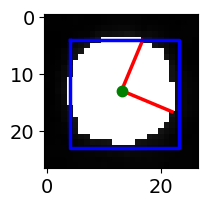

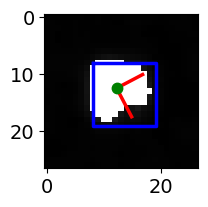

Investigating Model: Pretrained_Directional


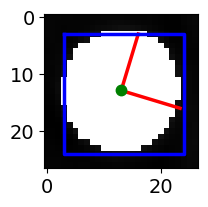

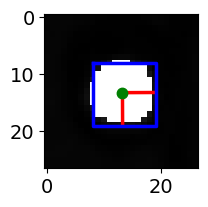

Investigating Model: Randomly_Initialized


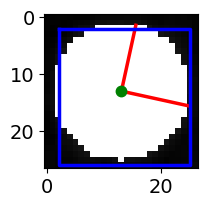

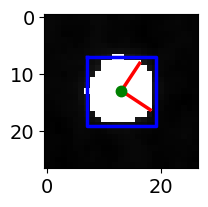

Investigating Model: Shuffled_Directional


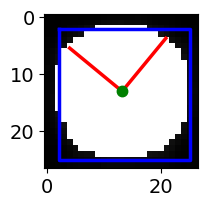

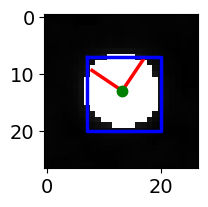

Investigating Model: Pretrained_Godfrey


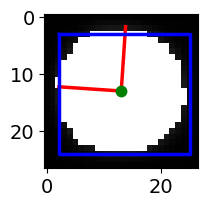

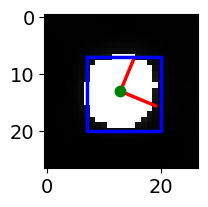

Investigating Model: Pretrained_Directional_One_Epoch


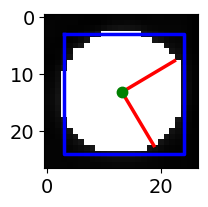

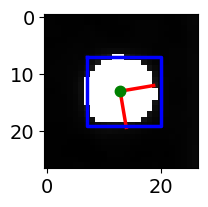

In [51]:
rf_radii = {}
for model in models:
    rf_radii[model] = calc_rf_size(model)

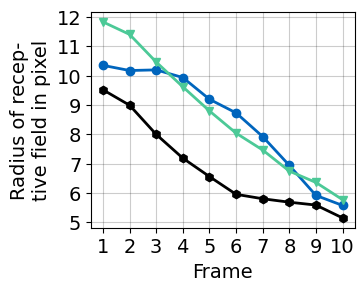

In [52]:
plot_rf_size_over_frames("figures/Figure_5", rf_radii, ['Fully_Trained', 'Pretrained_Directional', 'Randomly_Initialized'])

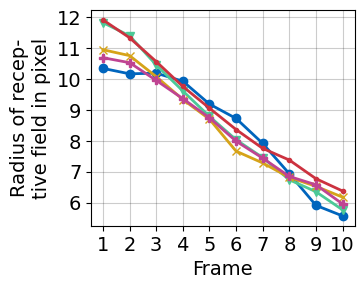

In [53]:
plot_rf_size_over_frames("figures/Supplementary_Figures/Figure_S3", rf_radii, ['Pretrained_Directional', 'Randomly_Initialized', 'Shuffled_Directional', 'Pretrained_Godfrey', 'Pretrained_Directional_One_Epoch'])

# Strength of Receptive Field

In [54]:
rf_strengths = {}
for model in models:
    rf_strengths[model] = calc_rf_strength(model)

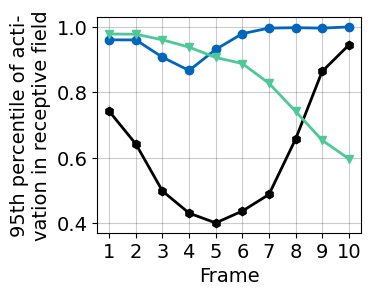

In [55]:
plot_rf_strength_over_frames("figures/Figure_5", rf_strengths, ['Fully_Trained', 'Pretrained_Directional', 'Randomly_Initialized'])

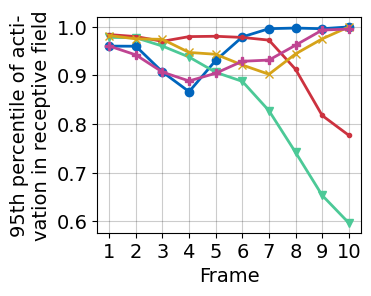

In [56]:
plot_rf_strength_over_frames("figures/Supplementary_Figures/Figure_S3", rf_strengths, ['Pretrained_Directional', 'Randomly_Initialized', 'Shuffled_Directional', 'Pretrained_Godfrey', 'Pretrained_Directional_One_Epoch'])

# Legends

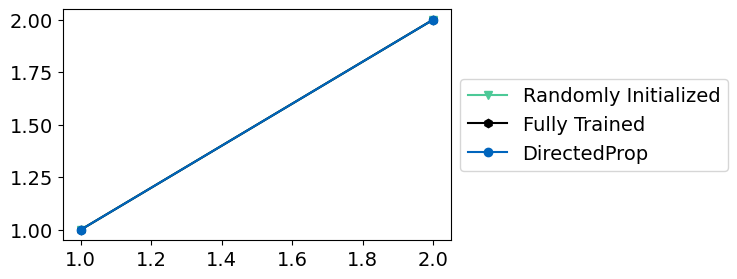

In [57]:
long_descr = {'Randomly_Initialized': 'Randomly Initialized',
              'Fully_Trained': 'Fully Trained',
              'Pretrained_Directional':'DirectedProp'}

fig, ax = plt.subplots(figsize=(5, 3))
for model in long_descr.keys():
    ax.plot([1,2], [1,2], color=designs[model]['color'], marker=designs[model]['marker'], label=long_descr[model])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('figures/Figure_5/legend.pdf', bbox_inches='tight')

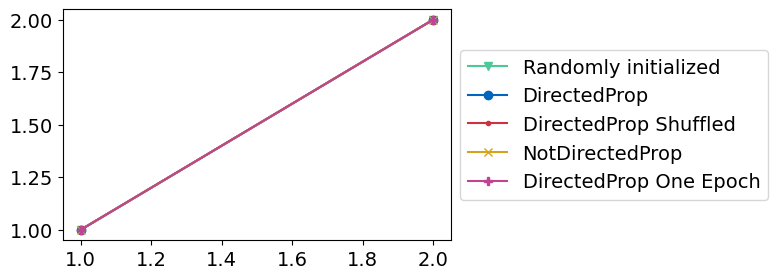

In [58]:
long_descr = {'Randomly_Initialized': 'Randomly initialized',
              'Pretrained_Directional': 'DirectedProp',
              'Shuffled_Directional': 'DirectedProp Shuffled',
              'Pretrained_Godfrey': 'NotDirectedProp',
              'Pretrained_Directional_One_Epoch': 'DirectedProp One Epoch',
              }

fig, ax = plt.subplots(figsize=(5, 3))
for model in long_descr.keys():
    ax.plot([1,2], [1,2], color=designs[model]['color'], marker=designs[model]['marker'], label=long_descr[model])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('figures/Supplementary_Figures/Figure_S3/legend.pdf', bbox_inches='tight')

# Look at percentage difference

In [59]:
size_frame=0
for model1 in models:
    for model2 in models:
        if model1 != model2:
            perc_dif = (rf_radii[model1][size_frame] - rf_radii[model2][size_frame]) / rf_radii[model1][size_frame] * 100
            print(f'Model {model1} vs. {model2}: {perc_dif:.2f}%')

Model Fully_Trained vs. Pretrained_Directional: -8.76%
Model Fully_Trained vs. Randomly_Initialized: -24.32%
Model Fully_Trained vs. Shuffled_Directional: -25.24%
Model Fully_Trained vs. Pretrained_Godfrey: -15.10%
Model Fully_Trained vs. Pretrained_Directional_One_Epoch: -12.39%
Model Pretrained_Directional vs. Fully_Trained: 8.05%
Model Pretrained_Directional vs. Randomly_Initialized: -14.31%
Model Pretrained_Directional vs. Shuffled_Directional: -15.16%
Model Pretrained_Directional vs. Pretrained_Godfrey: -5.84%
Model Pretrained_Directional vs. Pretrained_Directional_One_Epoch: -3.34%
Model Randomly_Initialized vs. Fully_Trained: 19.56%
Model Randomly_Initialized vs. Pretrained_Directional: 12.52%
Model Randomly_Initialized vs. Shuffled_Directional: -0.74%
Model Randomly_Initialized vs. Pretrained_Godfrey: 7.42%
Model Randomly_Initialized vs. Pretrained_Directional_One_Epoch: 9.60%
Model Shuffled_Directional vs. Fully_Trained: 20.16%
Model Shuffled_Directional vs. Pretrained_Directi

In [60]:
strength_frame=9
for model1 in models:
    for model2 in models:
        if model1 != model2:
            perc_dif = (rf_strengths[model1][strength_frame] - rf_strengths[model2][strength_frame]) / rf_strengths[model1][strength_frame] * 100
            print(f'Model {model1} vs. {model2}: {perc_dif:.2f}%')

Model Fully_Trained vs. Pretrained_Directional: -5.88%
Model Fully_Trained vs. Randomly_Initialized: 36.85%
Model Fully_Trained vs. Shuffled_Directional: 17.75%
Model Fully_Trained vs. Pretrained_Godfrey: -5.88%
Model Fully_Trained vs. Pretrained_Directional_One_Epoch: -5.42%
Model Pretrained_Directional vs. Fully_Trained: 5.55%
Model Pretrained_Directional vs. Randomly_Initialized: 40.36%
Model Pretrained_Directional vs. Shuffled_Directional: 22.32%
Model Pretrained_Directional vs. Pretrained_Godfrey: 0.00%
Model Pretrained_Directional vs. Pretrained_Directional_One_Epoch: 0.44%
Model Randomly_Initialized vs. Fully_Trained: -58.36%
Model Randomly_Initialized vs. Pretrained_Directional: -67.67%
Model Randomly_Initialized vs. Shuffled_Directional: -30.25%
Model Randomly_Initialized vs. Pretrained_Godfrey: -67.67%
Model Randomly_Initialized vs. Pretrained_Directional_One_Epoch: -66.93%
Model Shuffled_Directional vs. Fully_Trained: -21.58%
Model Shuffled_Directional vs. Pretrained_Directi